# Hyperparameter Adjustment in Regression-based Neural Networks for Predicting Support Case Durations

**Master Thesis code**

The code herein is part of my master's thesis work

IV.2020

## Utilities

In [0]:
!cat /proc/meminfo

In [0]:
!cat /proc/cpuinfo

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#helper method for calculating training duration
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [0]:
#plotting method
def plot_history(loss, val_loss,method_name):
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title(method_name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
  plt.show()

In [0]:
#imports
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from random import seed
from random import random
from sklearn import metrics

from scipy.stats import zscore
import datetime

import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

## Data Wrangling

### Load the log

Here we load the source file and apply some basic transformations.


In [114]:
#log will be preprocessed
df = pd.read_csv('/content/drive/My Drive/Student/VFU/s2/Process mining/logs/new/incident_event_log.csv',
                 na_values=['NA', '?'])

#1. get a list of all the columns 
columns = list(df) 

#2. show which columns have missing values
for column in columns: 
    if pd.isnull(df[column]).values.any():
        print(f'{column} has missing values')

#2.1. split the columns in two categories - droppable and non-droppable
droppable_na = ['opened_by','sys_created_by','sys_created_at','rfc','caused_by','closed_code','resolved_at']

#2.2. to the list of droppables we add those that we deem are not needed for the model
#we also drop incident number (not needed index)
droppable_all = ['number','opened_by','sys_created_by','sys_created_at','rfc','caused_by','closed_code',
                 'resolved_at','incident_state','active','sys_mod_count','opened_by','sys_updated_at',
                 'contact_type','knowledge','u_priority_confirmation','notify','resolved_at']
non_droppable_na = ['caller_id','location','category','subcategory','u_symptom','cmdb_ci','assignment_group',
                 'assigned_to','problem_id','vendor','resolved_by']

#3. For these columns, drop the ones we don't need, including columns that do not have NA values (2.2.)
print('------------------------------------')
print(f"Before drop: {list(df.columns)}")
df.drop(droppable_all, 1, inplace=True)
print('------------------------------------')
print(f"After drop: {list(df.columns)}")

#4. all non-droppable columns contain categorial values. Can't approximate, need to fill NA
for column in non_droppable_na:
  df[column].fillna(f'No {column}', inplace = True) # make sure to use the column name
print('------------------------------------')
#5 check for nulls again
columns = list(df)
for column in columns: 
    if pd.isnull(df[column]).values.any():
        print(f'{column} has missing values')
    else:
        print(f'{column} does not have missing values')

df.head()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


caller_id has missing values
opened_by has missing values
sys_created_by has missing values
sys_created_at has missing values
location has missing values
category has missing values
subcategory has missing values
u_symptom has missing values
cmdb_ci has missing values
assignment_group has missing values
assigned_to has missing values
problem_id has missing values
rfc has missing values
vendor has missing values
caused_by has missing values
closed_code has missing values
resolved_by has missing values
resolved_at has missing values
------------------------------------
Before drop: ['number', 'incident_state', 'active', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by', 'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by', 'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at
0,0,0,True,Caller 2403,29/02/2016 01:16,Updated by 21,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,05/03/2016 12:00
1,0,0,True,Caller 2403,29/02/2016 01:16,Updated by 642,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,05/03/2016 12:00
2,0,0,True,Caller 2403,29/02/2016 01:16,Updated by 804,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,05/03/2016 12:00
3,0,0,True,Caller 2403,29/02/2016 01:16,Updated by 908,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,05/03/2016 12:00
4,0,0,True,Caller 2403,29/02/2016 04:40,Updated by 746,Location 165,Category 40,Subcategory 215,Symptom 471,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,No problem_id,No vendor,Resolved by 81,06/03/2016 10:00


### Continuous variables

In this section we work on the continuous (numeric) variables.

### Calculate case duration
Here we calculate the duration of every case by subtracting `opened_at` from `closed_at`.

In [115]:
df['opened_at'] = pd.to_datetime(df['opened_at'], format='%d/%m/%Y %H:%M')
df['closed_at'] = pd.to_datetime(df['closed_at'], format='%d/%m/%Y %H:%M')
df['case_duration'] = df['closed_at'] - df['opened_at']
df['case_duration'] = df['case_duration']/np.timedelta64(1,'D')
df.dtypes

reassignment_count             int64
reopen_count                   int64
made_sla                        bool
caller_id                     object
opened_at             datetime64[ns]
sys_updated_by                object
location                      object
category                      object
subcategory                   object
u_symptom                     object
cmdb_ci                       object
impact                        object
urgency                       object
priority                      object
assignment_group              object
assigned_to                   object
problem_id                    object
vendor                        object
resolved_by                   object
closed_at             datetime64[ns]
case_duration                float64
dtype: object

In [116]:
df['case_duration']

0         5.447222
1         5.447222
2         5.447222
3         5.447222
4         6.222222
            ...   
141702    0.030556
141703    0.097917
141704    0.097917
141705    0.097917
141706    0.097917
Name: case_duration, Length: 141707, dtype: float64

### Standardization `case duration`

In [117]:
df['case_duration'] = zscore(df['case_duration']) 
# Calculate the z score of each value in the sample, relative to the sample mean and standard deviation.
# cases with average duration will be near zero, above zero is above average, and below zero is below average. 
# not needeed, can be left out
df.head()

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at,case_duration
0,0,0,True,Caller 2403,2016-02-29 01:16:00,Updated by 21,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,2016-03-05 12:00:00,-0.427676
1,0,0,True,Caller 2403,2016-02-29 01:16:00,Updated by 642,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,2016-03-05 12:00:00,-0.427676
2,0,0,True,Caller 2403,2016-02-29 01:16:00,Updated by 804,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,2016-03-05 12:00:00,-0.427676
3,0,0,True,Caller 2403,2016-02-29 01:16:00,Updated by 908,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,2016-03-05 12:00:00,-0.427676
4,0,0,True,Caller 2403,2016-02-29 04:40:00,Updated by 746,Location 165,Category 40,Subcategory 215,Symptom 471,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,No problem_id,No vendor,Resolved by 81,2016-03-06 10:00:00,-0.399137


### Encoding cyclical continuous features
`opened_at` and `closed_at` - making the assumption that day of week is what is of interest to us so we do not process the whole date. 


In [118]:
#convert to date and extract weekday in text
df['opened_at'] = df['opened_at'].apply(lambda x: x.strftime('%w')).astype(int)
df['closed_at'] = df['closed_at'].apply(lambda x: x.strftime('%w')).astype(int)
#Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
df.head()

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at,case_duration
0,0,0,True,Caller 2403,1,Updated by 21,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
1,0,0,True,Caller 2403,1,Updated by 642,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
2,0,0,True,Caller 2403,1,Updated by 804,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
3,0,0,True,Caller 2403,1,Updated by 908,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
4,0,0,True,Caller 2403,1,Updated by 746,Location 165,Category 40,Subcategory 215,Symptom 471,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,No problem_id,No vendor,Resolved by 81,0,-0.399137


In [119]:
df.dtypes # check dtypes

reassignment_count      int64
reopen_count            int64
made_sla                 bool
caller_id              object
opened_at               int64
sys_updated_by         object
location               object
category               object
subcategory            object
u_symptom              object
cmdb_ci                object
impact                 object
urgency                object
priority               object
assignment_group       object
assigned_to            object
problem_id             object
vendor                 object
resolved_by            object
closed_at               int64
case_duration         float64
dtype: object

### Encode `made_sla`


In [120]:
# convert made_sla
df['made_sla'] = df['made_sla'].astype(int)
df.head()

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at,case_duration
0,0,0,1,Caller 2403,1,Updated by 21,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
1,0,0,1,Caller 2403,1,Updated by 642,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
2,0,0,1,Caller 2403,1,Updated by 804,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
3,0,0,1,Caller 2403,1,Updated by 908,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
4,0,0,1,Caller 2403,1,Updated by 746,Location 165,Category 40,Subcategory 215,Symptom 471,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,No problem_id,No vendor,Resolved by 81,0,-0.399137


## Data exploration
Quantitative features analysis 

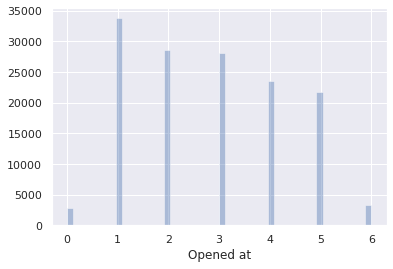

In [0]:
df['opened_at']=df['opened_at'].astype(int)
sns.set(style="darkgrid")
sns.distplot(df['opened_at'], kde=False, rug=False, axlabel='Opened at');

### Fitting gamma distribution to `case_duration`


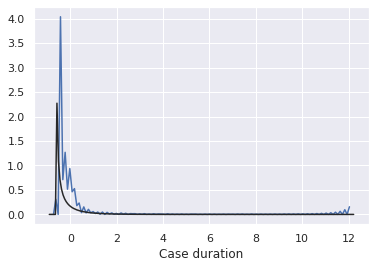

In [0]:
from scipy import stats

sns.distplot(df['case_duration'], hist=False, rug=False, kde=True, fit=stats.gamma, axlabel='Case duration');
#black line - gamm distribution
#blue line - variable values distribution

### Pairplot

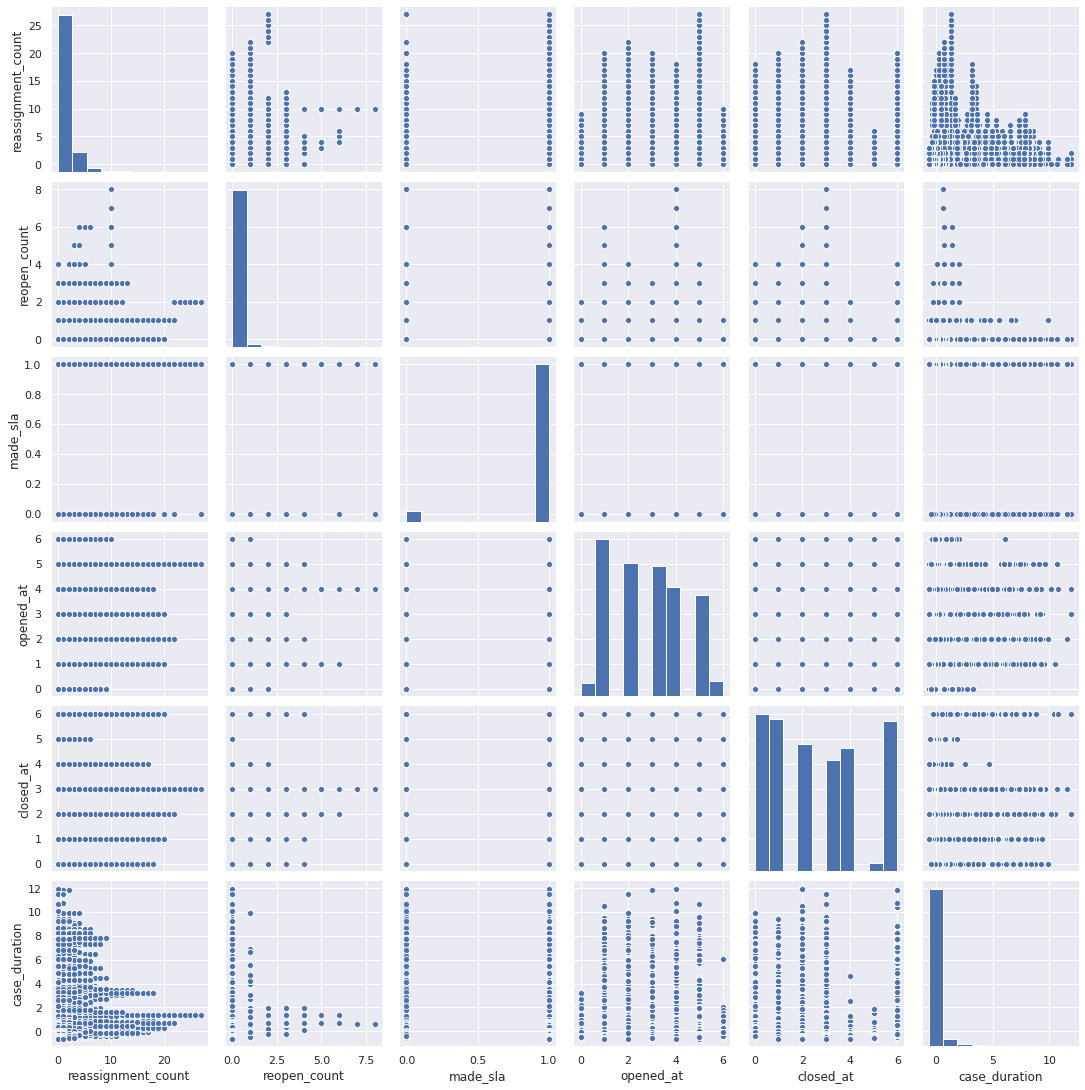

In [0]:
sns.pairplot(df)

## Categorical variables

This sections contains the different encoding methods used for representing text data:
- one-hot
- target
- binary
- hashing
- entity embeddings

### One-hot encoding 

#### get list of categorical columns

In [0]:
dummies = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'','u_symptom':'',
           'cmdb_ci':'','impact':'','urgency':'','priority':'','assignment_group':'','assigned_to':'',
           'problem_id':'','vendor':'','resolved_by':''}

# show unique values
for column in dummies:
  print(f'{column}: {len(list(df[column].unique()))} unique values')

caller_id: 5245 unique values
sys_updated_by: 845 unique values
location: 225 unique values
category: 59 unique values
subcategory: 255 unique values
u_symptom: 526 unique values
cmdb_ci: 51 unique values
impact: 3 unique values
urgency: 3 unique values
priority: 4 unique values
assignment_group: 79 unique values
assigned_to: 235 unique values
problem_id: 253 unique values
vendor: 5 unique values
resolved_by: 217 unique values


#### dummy-encode

In [0]:
for column in dummies:
  dummies[column] = pd.get_dummies(df[column],prefix=column)
  df = pd.concat([df,dummies[column]],axis=1)
  df.drop(column, axis=1, inplace=True)

df.head() 
#result is 8011 columns: 8005 dummies + 6 continuous columns

,reassignment_count,reopen_count,made_sla,opened_at,closed_at,case_duration,caller_id_Caller 10,caller_id_Caller 1000,caller_id_Caller 1001,caller_id_Caller 1002,caller_id_Caller 1004,caller_id_Caller 1005,caller_id_Caller 1006,caller_id_Caller 1007,caller_id_Caller 1008,caller_id_Caller 1009,caller_id_Caller 101,caller_id_Caller 1010,caller_id_Caller 1011,caller_id_Caller 1012,caller_id_Caller 1013,caller_id_Caller 1014,caller_id_Caller 1015,caller_id_Caller 1016,caller_id_Caller 1017,caller_id_Caller 1018,caller_id_Caller 1019,caller_id_Caller 102,caller_id_Caller 1020,caller_id_Caller 1021,caller_id_Caller 1022,caller_id_Caller 1023,caller_id_Caller 1024,caller_id_Caller 1025,caller_id_Caller 1026,caller_id_Caller 1027,caller_id_Caller 1028,caller_id_Caller 1029,caller_id_Caller 103,caller_id_Caller 1030,...,resolved_by_Resolved by 6,resolved_by_Resolved by 60,resolved_by_Resolved by 61,resolved_by_Resolved by 62,resolved_by_Resolved by 64,resolved_by_Resolved by 66,resolved_by_Resolved by 67,resolved_by_Resolved by 68,resolved_by_Resolved by 69,resolved_by_Resolved by 7,resolved_by_Resolved by 70,resolved_by_Resolved by 71,resolved_by_Resolved by 74,resolved_by_Resolved by 75,resolved_by_Resolved by 76,resolved_by_Resolved by 77,resolved_by_Resolved by 78,resolved_by_Resolved by 79,resolved_by_Resolved by 8,resolved_by_Resolved by 80,resolved_by_Resolved by 81,resolved_by_Resolved by 82,resolved_by_Resolved by 83,resolved_by_Resolved by 84,resolved_by_Resolved by 85,resolved_by_Resolved by 86,resolved_by_Resolved by 87,resolved_by_Resolved by 88,resolved_by_Resolved by 89,resolved_by_Resolved by 9,resolved_by_Resolved by 90,resolved_by_Resolved by 91,resolved_by_Resolved by 92,resolved_by_Resolved by 93,resolved_by_Resolved by 94,resolved_by_Resolved by 95,resolved_by_Resolved by 96,resolved_by_Resolved by 97,resolved_by_Resolved by 98,resolved_by_Resolved by 99
0,0,0,1,1,6,-0.427676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,6,-0.427676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,6,-0.427676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,6,-0.427676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,-0.399137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### generate x and y 
20% split

In [0]:
target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(target)], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(target)], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(target)], df.iloc[113366:][target]
X_test

,assigned_to_No assigned_to,assigned_to_Resolver 10,assigned_to_Resolver 100,assigned_to_Resolver 101,assigned_to_Resolver 102,assigned_to_Resolver 103,assigned_to_Resolver 104,assigned_to_Resolver 105,assigned_to_Resolver 106,assigned_to_Resolver 107,assigned_to_Resolver 108,assigned_to_Resolver 109,assigned_to_Resolver 11,assigned_to_Resolver 110,assigned_to_Resolver 111,assigned_to_Resolver 112,assigned_to_Resolver 114,assigned_to_Resolver 115,assigned_to_Resolver 116,assigned_to_Resolver 117,assigned_to_Resolver 118,assigned_to_Resolver 119,assigned_to_Resolver 12,assigned_to_Resolver 120,assigned_to_Resolver 121,assigned_to_Resolver 122,assigned_to_Resolver 123,assigned_to_Resolver 124,assigned_to_Resolver 125,assigned_to_Resolver 126,assigned_to_Resolver 127,assigned_to_Resolver 128,assigned_to_Resolver 129,assigned_to_Resolver 13,assigned_to_Resolver 130,assigned_to_Resolver 131,assigned_to_Resolver 132,assigned_to_Resolver 133,assigned_to_Resolver 134,assigned_to_Resolver 135,...,u_symptom_Symptom 65,u_symptom_Symptom 66,u_symptom_Symptom 67,u_symptom_Symptom 68,u_symptom_Symptom 69,u_symptom_Symptom 7,u_symptom_Symptom 70,u_symptom_Symptom 71,u_symptom_Symptom 72,u_symptom_Symptom 73,u_symptom_Symptom 74,u_symptom_Symptom 75,u_symptom_Symptom 77,u_symptom_Symptom 79,u_symptom_Symptom 8,u_symptom_Symptom 80,u_symptom_Symptom 81,u_symptom_Symptom 83,u_symptom_Symptom 84,u_symptom_Symptom 86,u_symptom_Symptom 87,u_symptom_Symptom 88,u_symptom_Symptom 89,u_symptom_Symptom 9,u_symptom_Symptom 92,u_symptom_Symptom 93,u_symptom_Symptom 94,u_symptom_Symptom 95,u_symptom_Symptom 96,u_symptom_Symptom 97,u_symptom_Symptom 98,u_symptom_Symptom 99,urgency_1 - High,urgency_2 - Medium,urgency_3 - Low,vendor_No vendor,vendor_Vendor 1,vendor_Vendor 2,vendor_Vendor 3,vendor_code 8s
113366,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
113367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
113368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
113369,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
113370,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141702,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
141703,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
141704,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
141705,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


#### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(0.001))) # Hidden 1
model.add(Dense(20, activation='linear', activity_regularizer=l2(0.001))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    shuffle=True,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
167/167 - 5s - loss: 0.5852 - mean_squared_error: 0.5841 - mean_absolute_error: 0.3658 - val_loss: 0.6792 - val_mean_squared_error: 0.6765 - val_mean_absolute_error: 0.4266
Epoch 2/10
167/167 - 5s - loss: 0.2580 - mean_squared_error: 0.2571 - mean_absolute_error: 0.2688 - val_loss: 0.6930 - val_mean_squared_error: 0.6918 - val_mean_absolute_error: 0.4549
Epoch 3/10
167/167 - 5s - loss: 0.1346 - mean_squared_error: 0.1336 - mean_absolute_error: 0.1995 - val_loss: 0.7024 - val_mean_squared_error: 0.7015 - val_mean_absolute_error: 0.4448
Epoch 4/10
167/167 - 5s - loss: 0.0811 - mean_squared_error: 0.0800 - mean_absolute_error: 0.1571 - val_loss: 0.7468 - val_mean_squared_error: 0.7463 - val_mean_absolute_error: 0.4587
Epoch 5/10
167/167 - 5s - loss: 0.0539 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1288 - val_loss: 0.7675 - val_mean_squared_error: 0.7670 - val_mean_absolute_error: 0.4601
Epoch 6/10
167/167 - 4s - loss: 0.0407 - mean_squared_error: 0.0396 - mean_absol

#### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
print('test results:', results)

886/886 [==============================] - 3s 3ms/step - loss: 1.1619 - mean_squared_error: 1.1613 - mean_absolute_error: 0.5823
test results: [1.161879062652588, 1.1612995862960815, 0.5822641253471375]


#### plot metrics

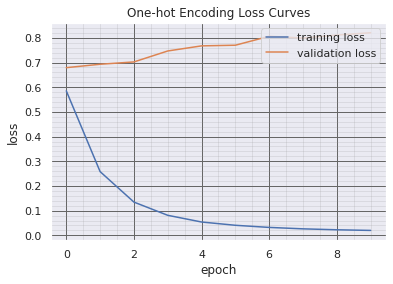

In [0]:
plot_history(history.history['loss'],history.history['val_loss'],'One-hot Encoding Loss Curves')

#### network layout

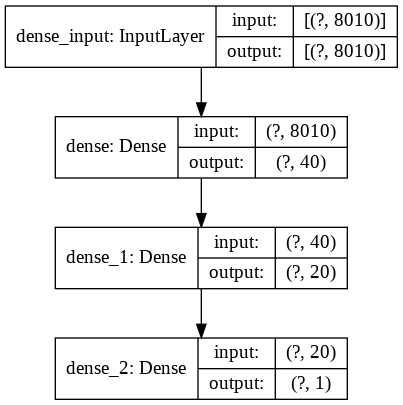

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                320440    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 321,281
Trainable params: 321,281
Non-trainable params: 0
_________________________________________________________________


### Target encoding

In [0]:
df.head()

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at,case_duration
0,0,0,1,Caller 2403,1,Updated by 21,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
1,0,0,1,Caller 2403,1,Updated by 642,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
2,0,0,1,Caller 2403,1,Updated by 804,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
3,0,0,1,Caller 2403,1,Updated by 908,Location 143,Category 55,Subcategory 170,Symptom 72,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 56,No assigned_to,No problem_id,No vendor,Resolved by 149,6,-0.427676
4,0,0,1,Caller 2403,1,Updated by 746,Location 165,Category 40,Subcategory 215,Symptom 471,No cmdb_ci,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,No problem_id,No vendor,Resolved by 81,0,-0.399137


In [0]:
encodable_columns = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'','u_symptom':'',
           'cmdb_ci':'','impact':'','urgency':'','priority':'','assignment_group':'','assigned_to':'',
           'problem_id':'','vendor':'','resolved_by':''}

for column_name in encodable_columns:
  random_values = []
  for column_value in df[column_name].values:
    random_values.append(random()) 
  encodable_columns[column_name] = random_values
    #how to calculate randoms? -> https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/
    #this is a new hyperparameter #we neeed a couple of runs, incl gaussian and sample
  s = pd.Series(encodable_columns[column_name], name = f'{column_name}_te')
  df = pd.concat([df,s],axis=1)
  df.drop(column_name, axis=1, inplace=True)

df.head()

#### Calculate smooth mean method

In [0]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df1, df2, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())

In [0]:
WEIGHT = 5
#lower - more overfitting
#weights is a new hyperparameter It’s quite intuitive really: 
#you’re saying that you require that there must be at least 5 values for the sample mean to overtake the global mean. 
#itrt=0

encodable_columns = {'caller_id_te':'','sys_updated_by_te':'','location_te':'','category_te':'','subcategory_te':'',
                     'u_symptom_te':'','cmdb_ci_te':'','impact_te':'','urgency_te':'','priority_te':'',
                     'assignment_group_te':'','assigned_to_te':'','problem_id_te':'','vendor_te':'','resolved_by_te':''}

for column_name in encodable_columns:
  df[column_name] = calc_smooth_mean(df1=df, df2=None, cat_name=column_name, target='case_duration', weight=WEIGHT)

In [0]:
WEIGHT = 5
#lower - more overfitting
#weights is a new hyperparameter It’s quite intuitive really: 
#you’re saying that you require that there must be at least 5 values for the sample mean to overtake the global mean. 
#itrt=0

encodable_columns = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'',
                     'u_symptom':'','cmdb_ci':'','impact':'','urgency':'','priority':'',
                     'assignment_group':'','assigned_to':'','problem_id':'','vendor':'','resolved_by':''}

for column_name in encodable_columns:
  df[column_name] = calc_smooth_mean(df1=df, df2=None, cat_name=column_name, target='case_duration', weight=WEIGHT)

In [0]:
df

,reassignment_count,reopen_count,made_sla,caller_id,opened_at,sys_updated_by,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,problem_id,vendor,resolved_by,closed_at,case_duration
0,0,0,1,-0.263873,1,-0.155682,-0.008741,0.901104,-0.113070,1.064164,0.000259,-0.002887,-0.002397,-0.002416,-0.158640,-0.010555,-0.000341,-0.003122,0.090038,6,-0.427676
1,0,0,1,-0.263873,1,0.184683,-0.008741,0.901104,-0.113070,1.064164,0.000259,-0.002887,-0.002397,-0.002416,-0.158640,-0.010555,-0.000341,-0.003122,0.090038,6,-0.427676
2,0,0,1,-0.263873,1,0.106636,-0.008741,0.901104,-0.113070,1.064164,0.000259,-0.002887,-0.002397,-0.002416,-0.158640,-0.010555,-0.000341,-0.003122,0.090038,6,-0.427676
3,0,0,1,-0.263873,1,-0.187839,-0.008741,0.901104,-0.113070,1.064164,0.000259,-0.002887,-0.002397,-0.002416,-0.158640,-0.010555,-0.000341,-0.003122,0.090038,6,-0.427676
4,0,0,1,-0.263873,1,-0.043555,-0.256577,-0.024140,-0.068116,-0.146755,0.000259,-0.002887,-0.002397,-0.002416,-0.249444,0.657358,-0.000341,-0.003122,0.227120,0,-0.399137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141702,1,0,1,-0.186096,4,-0.103566,0.067866,-0.173691,-0.219798,0.203643,0.000259,-0.002887,-0.002397,-0.002416,1.033381,-0.382842,-0.000341,-0.003122,1.039454,4,-0.627138
141703,0,0,1,-0.186096,4,-0.187839,0.067866,-0.173691,-0.219798,0.203643,0.000259,-0.002887,-0.002397,-0.002416,-0.249444,-0.382842,-0.000341,-0.003122,1.039454,4,-0.624657
141704,1,0,1,-0.186096,4,-0.117615,0.067866,-0.173691,-0.219798,0.203643,0.000259,-0.002887,-0.002397,-0.002416,1.033381,-0.010555,-0.000341,-0.003122,1.039454,4,-0.624657
141705,1,0,1,-0.186096,4,-0.103566,0.067866,-0.173691,-0.219798,0.203643,0.000259,-0.002887,-0.002397,-0.002416,1.033381,-0.382842,-0.000341,-0.003122,1.039454,4,-0.624657


#### generate x and y 
20% split


In [0]:
target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(target)], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(target)], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(target)], df.iloc[113366:][target]
X_train

,assigned_to,assignment_group,caller_id,category,closed_at,cmdb_ci,impact,location,made_sla,opened_at,priority,problem_id,reassignment_count,reopen_count,resolved_by,subcategory,sys_updated_by,u_symptom,urgency,vendor
0,-0.010555,-0.158640,-0.263873,0.901104,6,0.000259,-0.002887,-0.008741,1,1,-0.002416,-0.000341,0,0,0.090038,-0.113070,-0.155682,1.064164,-0.002397,-0.003122
1,-0.010555,-0.158640,-0.263873,0.901104,6,0.000259,-0.002887,-0.008741,1,1,-0.002416,-0.000341,0,0,0.090038,-0.113070,0.184683,1.064164,-0.002397,-0.003122
2,-0.010555,-0.158640,-0.263873,0.901104,6,0.000259,-0.002887,-0.008741,1,1,-0.002416,-0.000341,0,0,0.090038,-0.113070,0.106636,1.064164,-0.002397,-0.003122
3,-0.010555,-0.158640,-0.263873,0.901104,6,0.000259,-0.002887,-0.008741,1,1,-0.002416,-0.000341,0,0,0.090038,-0.113070,-0.187839,1.064164,-0.002397,-0.003122
4,0.657358,-0.249444,-0.263873,-0.024140,0,0.000259,-0.002887,-0.256577,1,1,-0.002416,-0.000341,0,0,0.227120,-0.068116,-0.043555,-0.146755,-0.002397,-0.003122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85019,-0.010555,0.105780,0.431733,-0.248082,0,0.000259,-0.002887,-0.014307,1,1,-0.002416,-0.000341,0,0,-0.162511,0.100471,-0.187839,-0.325879,-0.002397,-0.003122
85020,-0.010555,0.105780,0.431733,-0.248082,0,0.000259,-0.002887,-0.014307,1,1,-0.002416,-0.000341,0,0,-0.162511,0.100471,-0.010758,-0.325879,-0.002397,-0.003122
85021,-0.010555,0.105780,0.431733,-0.248082,0,0.000259,-0.002887,-0.014307,1,1,-0.002416,-0.000341,0,0,-0.162511,0.100471,-0.016413,-0.325879,-0.002397,-0.003122
85022,-0.010555,-0.249444,0.431733,-0.248082,0,0.000259,-0.002887,-0.014307,1,1,-0.002416,-0.000341,1,0,-0.162511,0.100471,-0.016413,-0.325879,-0.002397,-0.003122


#### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    shuffle=True,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
167/167 - 1s - loss: 0.8004 - mean_squared_error: 0.7751 - mean_absolute_error: 0.4863 - val_loss: 0.5050 - val_mean_squared_error: 0.4798 - val_mean_absolute_error: 0.3568
Epoch 2/10
167/167 - 1s - loss: 0.5023 - mean_squared_error: 0.4800 - mean_absolute_error: 0.3587 - val_loss: 0.4570 - val_mean_squared_error: 0.4375 - val_mean_absolute_error: 0.3267
Epoch 3/10
167/167 - 1s - loss: 0.4568 - mean_squared_error: 0.4404 - mean_absolute_error: 0.3348 - val_loss: 0.4360 - val_mean_squared_error: 0.4208 - val_mean_absolute_error: 0.3152
Epoch 4/10
167/167 - 1s - loss: 0.4337 - mean_squared_error: 0.4202 - mean_absolute_error: 0.3234 - val_loss: 0.4229 - val_mean_squared_error: 0.4107 - val_mean_absolute_error: 0.3095
Epoch 5/10
167/167 - 1s - loss: 0.4177 - mean_squared_error: 0.4070 - mean_absolute_error: 0.3159 - val_loss: 0.4190 - val_mean_squared_error: 0.4088 - val_mean_absolute_error: 0.3085
Epoch 6/10
167/167 - 1s - loss: 0.4079 - mean_squared_error: 0.3970 - mean_absol

#### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

886/886 [==============================] - 2s 3ms/step - loss: 0.5036 - mean_squared_error: 0.4986 - mean_absolute_error: 0.3387
test loss, test acc: [0.5035956501960754, 0.4986068308353424, 0.3386916220188141]


#### plot metrics

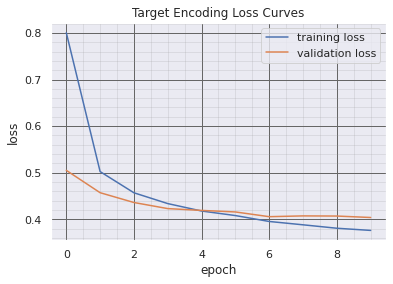

In [0]:
plot_history(history.history['loss'],history.history['val_loss'],'Target Encoding Loss Curves')

In [0]:
plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True)

#### network layout

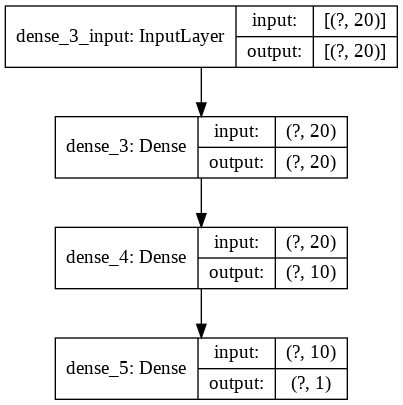

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


### Binary encoding


In [0]:
pip install category_encoders

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
import category_encoders as ce

df_ce = df.copy()

#all features subject to encoding
bec = ['caller_id','sys_updated_by','location','category','subcategory','u_symptom','cmdb_ci',
       'impact','urgency','priority','assignment_group','assigned_to', 'problem_id','vendor',
       'resolved_by']

encoder = ce.BinaryEncoder(cols=bec)
df_binary = encoder.fit_transform(df_ce)

df_binary.head() #works -> 122 columns, much less than dummy encoding

,reassignment_count,reopen_count,made_sla,caller_id_0,caller_id_1,caller_id_2,caller_id_3,caller_id_4,caller_id_5,caller_id_6,caller_id_7,caller_id_8,caller_id_9,caller_id_10,caller_id_11,caller_id_12,caller_id_13,opened_at,sys_updated_by_0,sys_updated_by_1,sys_updated_by_2,sys_updated_by_3,sys_updated_by_4,sys_updated_by_5,sys_updated_by_6,sys_updated_by_7,sys_updated_by_8,sys_updated_by_9,sys_updated_by_10,location_0,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,category_0,category_1,...,assignment_group_1,assignment_group_2,assignment_group_3,assignment_group_4,assignment_group_5,assignment_group_6,assignment_group_7,assigned_to_0,assigned_to_1,assigned_to_2,assigned_to_3,assigned_to_4,assigned_to_5,assigned_to_6,assigned_to_7,assigned_to_8,problem_id_0,problem_id_1,problem_id_2,problem_id_3,problem_id_4,problem_id_5,problem_id_6,problem_id_7,problem_id_8,vendor_0,vendor_1,vendor_2,vendor_3,resolved_by_0,resolved_by_1,resolved_by_2,resolved_by_3,resolved_by_4,resolved_by_5,resolved_by_6,resolved_by_7,resolved_by_8,closed_at,case_duration
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,6,-0.427676
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,6,-0.427676
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,6,-0.427676
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,6,-0.427676
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-0.399137


#### generate x and y

In [0]:
target = ['case_duration']

X_train, y_train = df_binary.iloc[:85024][df_binary.columns.difference(target)], df_binary.iloc[:85024][target]
X_val, y_val = df_binary.iloc[85025:113366][df_binary.columns.difference(target)], df_binary.iloc[85025:113366][target]
X_test, y_test = df_binary.iloc[113366:][df_binary.columns.difference(target)], df_binary.iloc[113366:][target]
X_test

,assigned_to_0,assigned_to_1,assigned_to_2,assigned_to_3,assigned_to_4,assigned_to_5,assigned_to_6,assigned_to_7,assigned_to_8,assignment_group_0,assignment_group_1,assignment_group_2,assignment_group_3,assignment_group_4,assignment_group_5,assignment_group_6,assignment_group_7,caller_id_0,caller_id_1,caller_id_10,caller_id_11,caller_id_12,caller_id_13,caller_id_2,caller_id_3,caller_id_4,caller_id_5,caller_id_6,caller_id_7,caller_id_8,caller_id_9,category_0,category_1,category_2,category_3,category_4,category_5,category_6,closed_at,cmdb_ci_0,...,resolved_by_7,resolved_by_8,subcategory_0,subcategory_1,subcategory_2,subcategory_3,subcategory_4,subcategory_5,subcategory_6,subcategory_7,subcategory_8,sys_updated_by_0,sys_updated_by_1,sys_updated_by_10,sys_updated_by_2,sys_updated_by_3,sys_updated_by_4,sys_updated_by_5,sys_updated_by_6,sys_updated_by_7,sys_updated_by_8,sys_updated_by_9,u_symptom_0,u_symptom_1,u_symptom_10,u_symptom_2,u_symptom_3,u_symptom_4,u_symptom_5,u_symptom_6,u_symptom_7,u_symptom_8,u_symptom_9,urgency_0,urgency_1,urgency_2,vendor_0,vendor_1,vendor_2,vendor_3
113366,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,6,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1
113367,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,6,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1
113368,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,6,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1
113369,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,1,1,0,6,0,...,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
113370,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,1,1,0,6,0,...,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141702,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,4,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1
141703,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,4,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1
141704,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,4,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1
141705,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,4,0,...,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1


#### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
167/167 - 1s - loss: 1.3388 - mean_squared_error: 1.3289 - mean_absolute_error: 0.6428 - val_loss: 0.8824 - val_mean_squared_error: 0.8715 - val_mean_absolute_error: 0.4987
Epoch 2/10
167/167 - 1s - loss: 0.9447 - mean_squared_error: 0.9207 - mean_absolute_error: 0.4880 - val_loss: 0.8435 - val_mean_squared_error: 0.8349 - val_mean_absolute_error: 0.5034
Epoch 3/10
167/167 - 1s - loss: 0.8517 - mean_squared_error: 0.8434 - mean_absolute_error: 0.4636 - val_loss: 0.7905 - val_mean_squared_error: 0.7837 - val_mean_absolute_error: 0.4578
Epoch 4/10
167/167 - 1s - loss: 0.7970 - mean_squared_error: 0.7836 - mean_absolute_error: 0.4362 - val_loss: 0.7516 - val_mean_squared_error: 0.7459 - val_mean_absolute_error: 0.4354
Epoch 5/10
167/167 - 1s - loss: 0.7374 - mean_squared_error: 0.7319 - mean_absolute_error: 0.4195 - val_loss: 0.7338 - val_mean_squared_error: 0.7289 - val_mean_absolute_error: 0.4268
Epoch 6/10
167/167 - 1s - loss: 0.7120 - mean_squared_error: 0.6949 - mean_absol

#### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

886/886 [==============================] - 2s 3ms/step - loss: 0.7875 - mean_squared_error: 0.7829 - mean_absolute_error: 0.4918
test loss, test acc: [0.7874535322189331, 0.7829135656356812, 0.49176743626594543]


#### plot metrics

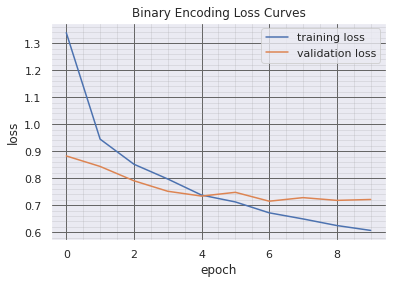

In [0]:
#plot training metrics
plot_history(history.history['loss'],history.history['val_loss'],'Binary Encoding Loss Curves')

#### network layout

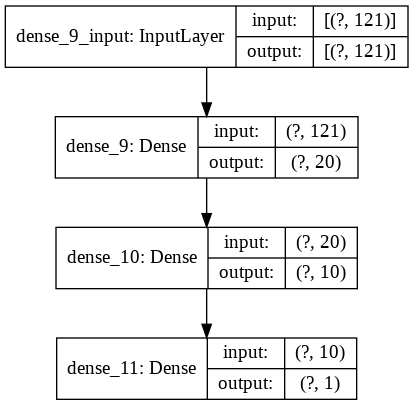

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                2440      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________


##### feature encoding log scale
Graph showing the resulting binary-encoded feature count as a function of feature cardinality.

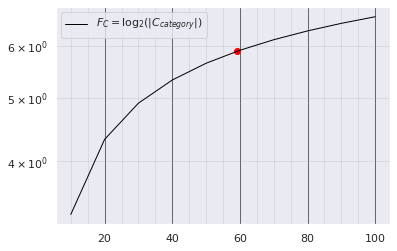

In [0]:
X = np.linspace(10, 100, 10)

plt.yscale('log')

plt.plot(X, np.log2(X), c = 'black', lw = 1., label = r'$F_C=\log_2(|C_{category}|)$')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

xi = 59
yi = np.log2(xi)
plt.scatter(xi,yi, color='red')

plt.legend()
plt.show()

### Hashing encoding  


In [0]:
pip install category_encoders

In [0]:
import category_encoders as ce

df_ce = df.copy()

hec = ['caller_id','sys_updated_by','location','category','subcategory','u_symptom','cmdb_ci',
       'impact','urgency','priority','assignment_group','assigned_to', 'problem_id','vendor',
       'resolved_by']

#encoder = ce.HashingEncoder(cols=hec, verbose=1, hash_method='sha256', n_components=15) 
df_hashing = ce.HashingEncoder.hashing_trick(df_ce,hashing_method='sha256', N=15, cols=hec, make_copy=False)

#uses MD5 by default
#n_components = 8 by default, set to 15 and to 50 for comparison
#source code http://contrib.scikit-learn.org/categorical-encoding/_modules/category_encoders/hashing.html

In [80]:
df_hashing.shape

(141707, 21)

##### normalize

In [0]:
for i in range(0,15):
  df_hashing[f'col_{i}'] = zscore(df_hashing[f'col_{i}']) 
df_hashing.iloc[:5,:]
#normalizing the encoded values penalized the model

In [81]:
df_hashing.shape

(141707, 21)

#### generate x and y

In [82]:
target = ['case_duration']

X_train, y_train = df_hashing.iloc[:85024][df_hashing.columns.difference(target)], df_hashing.iloc[:85024][target]
X_val, y_val = df_hashing.iloc[85025:113366][df_hashing.columns.difference(target)], df_hashing.iloc[85025:113366][target]
X_test, y_test = df_hashing.iloc[113366:][df_hashing.columns.difference(target)], df_hashing.iloc[113366:][target]
X_test

,closed_at,col_0,col_1,col_10,col_11,col_12,col_13,col_14,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,made_sla,opened_at,reassignment_count,reopen_count
113366,6,1,0,1,0,0,1,1,1,0,1,2,0,3,2,2,1,1,0,0
113367,6,1,0,1,0,0,1,1,1,0,1,2,0,2,2,3,1,1,0,0
113368,6,1,0,1,0,0,1,1,1,0,0,2,0,3,2,3,1,1,0,0
113369,6,1,0,0,0,0,1,2,0,0,0,1,1,3,2,4,1,1,0,0
113370,6,1,0,0,0,0,1,2,0,1,0,1,1,2,2,4,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141702,4,1,0,1,2,1,0,2,0,0,0,3,0,2,1,2,1,4,1,0
141703,4,1,0,1,2,0,0,2,0,0,0,2,0,3,2,2,1,4,0,0
141704,4,1,0,1,2,2,0,2,0,0,0,2,0,3,0,2,1,4,1,0
141705,4,1,0,1,2,1,0,2,0,0,0,3,0,2,1,2,1,4,1,0


#### train model

In [84]:
import time
import matplotlib.pyplot as plt
from keras.regularizers import l1,l2

start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
167/167 - 1s - loss: 1.1877 - mean_squared_error: 1.1410 - mean_absolute_error: 0.5583 - val_loss: 0.9260 - val_mean_squared_error: 0.8918 - val_mean_absolute_error: 0.5092
Epoch 2/10
167/167 - 1s - loss: 1.0863 - mean_squared_error: 1.0550 - mean_absolute_error: 0.4964 - val_loss: 0.8926 - val_mean_squared_error: 0.8730 - val_mean_absolute_error: 0.5001
Epoch 3/10
167/167 - 1s - loss: 1.0583 - mean_squared_error: 1.0435 - mean_absolute_error: 0.4932 - val_loss: 0.8798 - val_mean_squared_error: 0.8674 - val_mean_absolute_error: 0.4859
Epoch 4/10
167/167 - 1s - loss: 1.0452 - mean_squared_error: 1.0354 - mean_absolute_error: 0.4900 - val_loss: 0.8834 - val_mean_squared_error: 0.8744 - val_mean_absolute_error: 0.5109
Epoch 5/10
167/167 - 1s - loss: 1.0391 - mean_squared_error: 1.0273 - mean_absolute_error: 0.4897 - val_loss: 0.8760 - val_mean_squared_error: 0.8695 - val_mean_absolute_error: 0.4971
Epoch 6/10
167/167 - 1s - loss: 1.0238 - mean_squared_error: 1.0189 - mean_absol

#### evaluate model

In [85]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

886/886 [==============================] - 2s 3ms/step - loss: 0.7349 - mean_squared_error: 0.7306 - mean_absolute_error: 0.4645
test loss, test acc: [0.7349252104759216, 0.7305837869644165, 0.46454137563705444]


#### plot metrics

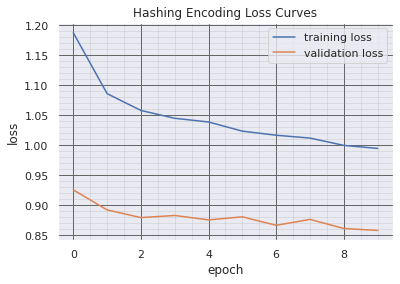

In [89]:
#plot training metrics
plot_history(history.history['loss'],history.history['val_loss'],'Hashing Encoding Loss Curves')

#### network layout

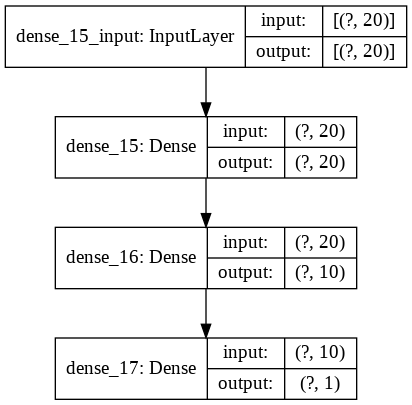

In [90]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [91]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


### Entity embeddings

#### Feature cardinality

In [97]:
embed_cols=[i for i in df.select_dtypes(include=['object'])]

for i in embed_cols:
    print(i,df[i].nunique())

caller_id 5245
sys_updated_by 845
location 225
category 59
subcategory 255
u_symptom 526
cmdb_ci 51
impact 3
urgency 3
priority 4
assignment_group 79
assigned_to 235
problem_id 253
vendor 5
resolved_by 217


#### Categorical Features To List Format

We have to convert data to list format to match the network structure.

The following function takes the list of categorical features, and prepare such lists for the NN input.

#### Data split

In [121]:
categorical_features = ['caller_id','sys_updated_by','location','category','subcategory',
                        'u_symptom','cmdb_ci','impact','urgency','priority','assignment_group',
                        'assigned_to', 'problem_id','vendor','resolved_by']

target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(['case_duration'])], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(['case_duration'])], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(['case_duration'])], df.iloc[113366:][target]
X_test

,assigned_to,assignment_group,caller_id,category,closed_at,cmdb_ci,impact,location,made_sla,opened_at,priority,problem_id,reassignment_count,reopen_count,resolved_by,subcategory,sys_updated_by,u_symptom,urgency,vendor
113366,No assigned_to,Group 70,Caller 338,Category 42,6,No cmdb_ci,2 - Medium,Location 161,1,1,3 - Moderate,No problem_id,0,0,Resolved by 103,Subcategory 223,Updated by 429,Symptom 534,2 - Medium,No vendor
113367,Resolver 115,Group 70,Caller 338,Category 42,6,No cmdb_ci,2 - Medium,Location 161,1,1,3 - Moderate,No problem_id,0,0,Resolved by 103,Subcategory 223,Updated by 429,Symptom 534,2 - Medium,No vendor
113368,Resolver 115,Group 70,Caller 338,Category 42,6,No cmdb_ci,2 - Medium,Location 161,1,1,3 - Moderate,No problem_id,0,0,Resolved by 103,Subcategory 223,Updated by 908,Symptom 534,2 - Medium,No vendor
113369,No assigned_to,Group 70,Caller 5052,Category 26,6,No cmdb_ci,2 - Medium,Location 161,1,1,3 - Moderate,No problem_id,0,0,Resolved by 151,Subcategory 275,Updated by 908,No u_symptom,2 - Medium,No vendor
113370,No assigned_to,Group 70,Caller 5052,Category 26,6,No cmdb_ci,2 - Medium,Location 161,1,1,3 - Moderate,No problem_id,0,0,Resolved by 151,Subcategory 275,Updated by 44,No u_symptom,2 - Medium,No vendor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141702,Resolver 10,Group 31,Caller 116,Category 42,4,No cmdb_ci,2 - Medium,Location 204,1,4,3 - Moderate,No problem_id,1,0,Resolved by 9,Subcategory 223,Updated by 27,Symptom 494,2 - Medium,No vendor
141703,Resolver 10,Group 70,Caller 116,Category 42,4,No cmdb_ci,2 - Medium,Location 204,1,4,3 - Moderate,No problem_id,0,0,Resolved by 9,Subcategory 223,Updated by 908,Symptom 494,2 - Medium,No vendor
141704,No assigned_to,Group 31,Caller 116,Category 42,4,No cmdb_ci,2 - Medium,Location 204,1,4,3 - Moderate,No problem_id,1,0,Resolved by 9,Subcategory 223,Updated by 60,Symptom 494,2 - Medium,No vendor
141705,Resolver 10,Group 31,Caller 116,Category 42,4,No cmdb_ci,2 - Medium,Location 204,1,4,3 - Moderate,No problem_id,1,0,Resolved by 9,Subcategory 223,Updated by 27,Symptom 494,2 - Medium,No vendor


In [99]:
X_train.shape

(85024, 20)

In [0]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

#### Embedding dimension (hyperparameter)

In [124]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorical Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorical Variable: assigned_to Unique Categories: 196 Embedding Size: 50
Categorical Variable: assignment_group Unique Categories: 72 Embedding Size: 36
Categorical Variable: caller_id Unique Categories: 4106 Embedding Size: 50
Categorical Variable: category Unique Categories: 44 Embedding Size: 22
Categorical Variable: cmdb_ci Unique Categories: 45 Embedding Size: 23
Categorical Variable: impact Unique Categories: 3 Embedding Size: 2
Categorical Variable: location Unique Categories: 190 Embedding Size: 50
Categorical Variable: priority Unique Categories: 4 Embedding Size: 2
Categorical Variable: problem_id Unique Categories: 131 Embedding Size: 50
Categorical Variable: resolved_by Unique Categories: 176 Embedding Size: 50
Categorical Variable: subcategory Unique Categories: 211 Embedding Size: 50
Categorical Variable: sys_updated_by Unique Categories: 601 Embedding Size: 50
Categorical Variable: u_symptom Unique Categories: 471 Embedding Size: 50
Categorical Variable: urgency Uniqu

In [125]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_assigned_to
Input_assignment_group
Input_caller_id
Input_category
Input_cmdb_ci
Input_impact
Input_location
Input_priority
Input_problem_id
Input_resolved_by
Input_subcategory
Input_sys_updated_by
Input_u_symptom
Input_urgency
Input_vendor


In [0]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 100))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='linear')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mae'])

#### Network architecture

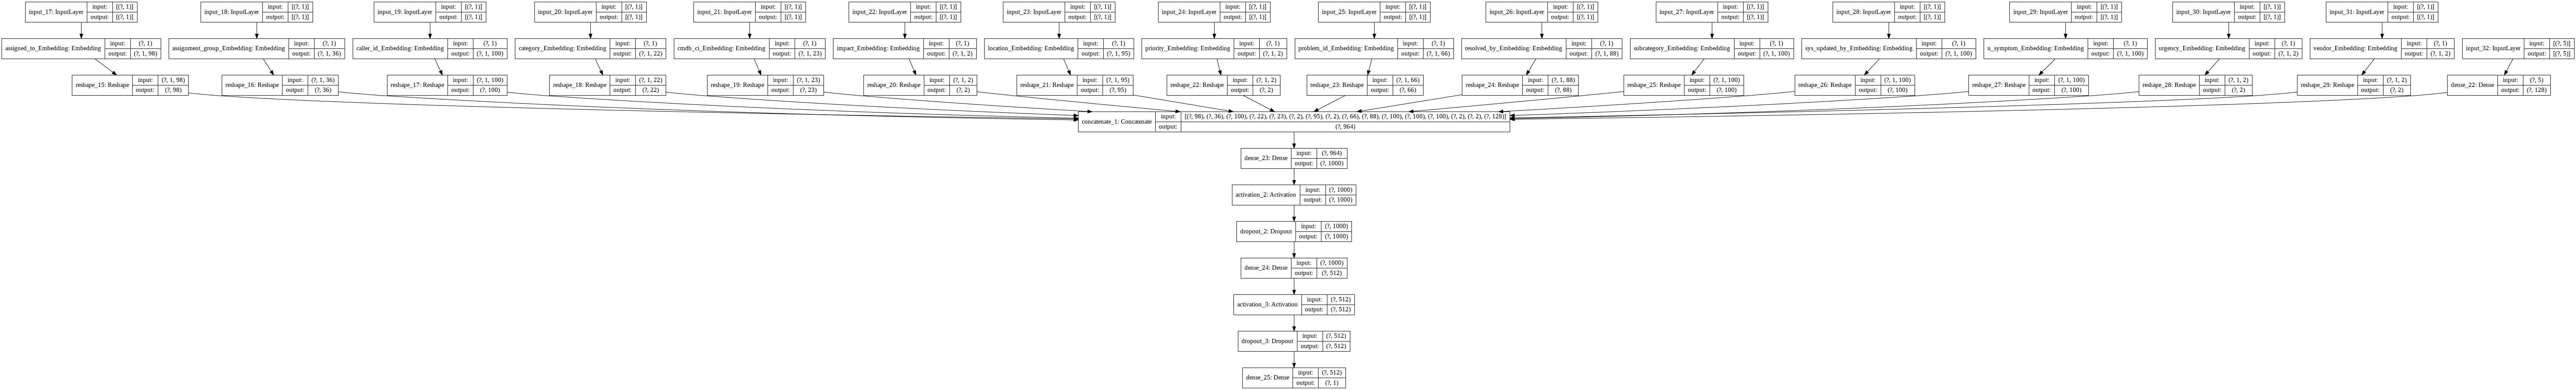

In [127]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [128]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

#### Training

In [0]:
X_train_list,X_val_list,X_test_list = preproc(X_train, X_val, X_test)

In [130]:
X_train_list

[array([0, 0, 0, ..., 0, 0, 0]),
 array([43, 43, 43, ...,  9, 58, 58]),
 array([1123, 1123, 1123, ..., 1613, 1613, 1613]),
 array([34, 34, 34, ..., 31, 31, 31]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([ 36,  36,  36, ..., 183, 183, 183]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([48, 48, 48, ..., 49, 49, 49]),
 array([ 58,  58,  58, ..., 183, 183, 183]),
 array([ 73, 354, 460, ..., 513, 513,   8]),
 array([451, 451, 451, ...,   5,   5,   5]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([[6, 1, 1, 0, 0],
        [6, 1, 1, 0, 0],
        [6, 1, 1, 0, 0],
        ...,
        [0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0]])]

In [131]:
start_time = time.time()

history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val), epochs = 10, batch_size = 512, verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
167/167 - 4s - loss: 0.6146 - mse: 0.6154 - mae: 0.3731 - val_loss: 0.8406 - val_mse: 0.8432 - val_mae: 0.4432
Epoch 2/10
167/167 - 3s - loss: 0.1885 - mse: 0.1881 - mae: 0.2290 - val_loss: 0.7734 - val_mse: 0.7749 - val_mae: 0.3841
Epoch 3/10
167/167 - 3s - loss: 0.1153 - mse: 0.1156 - mae: 0.1888 - val_loss: 0.8112 - val_mse: 0.8135 - val_mae: 0.3832
Epoch 4/10
167/167 - 3s - loss: 0.0854 - mse: 0.0852 - mae: 0.1633 - val_loss: 0.8664 - val_mse: 0.8691 - val_mae: 0.4128
Epoch 5/10
167/167 - 3s - loss: 0.0678 - mse: 0.0679 - mae: 0.1483 - val_loss: 0.8014 - val_mse: 0.8033 - val_mae: 0.4031
Epoch 6/10
167/167 - 3s - loss: 0.0564 - mse: 0.0566 - mae: 0.1366 - val_loss: 0.8343 - val_mse: 0.8362 - val_mae: 0.4189
Epoch 7/10
167/167 - 3s - loss: 0.0490 - mse: 0.0491 - mae: 0.1263 - val_loss: 0.8153 - val_mse: 0.8169 - val_mae: 0.3893
Epoch 8/10
167/167 - 3s - loss: 0.0414 - mse: 0.0416 - mae: 0.1166 - val_loss: 0.8083 - val_mse: 0.8102 - val_mae: 0.3901
Epoch 9/10
167/167 - 3s 

#### Evaluate model

In [132]:
results = model.evaluate(X_test_list, y_test, verbose=1)
results
print('test loss, test acc:', results)

886/886 [==============================] - 5s 6ms/step - loss: 1.0352 - mse: 1.0351 - mae: 0.4558
test loss, test acc: [1.035155177116394, 1.03513765335083, 0.4558061361312866]


#### Metrics

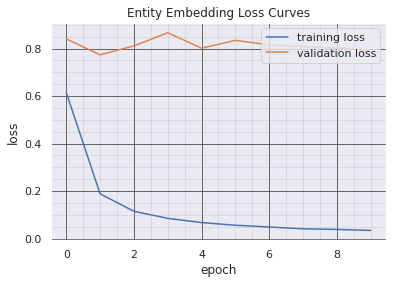

In [133]:
plot_history(history.history['loss'],history.history['val_loss'],'Entity Embedding Loss Curves')

## Final metrics and comparison


### overall loss values

#### define df

In [0]:
encoding = ['one-hot I','one-hot II','target I w=5','target II w-5','target I w-100','target II w-100',
'binary I','binary II','hashing I - default','hashing II - default','hashing III - default','hashing IV - default',
'hashing I - normalized','hashing II - normalized','hashing III - normalized','hashing IV - normalized',
'embeddings I - e-50','embeddings II - e-100','embeddings III - e-50','embeddings IV - e-100']
train_loss = [0.0177,0.0042,0.3865,0.2962,0.4363,0.3390,0.5168,0.2635,0.9817,0.8860,0.6940,0.4882,0.9985,
              0.9178,0.6920,0.4633,0.0356,0.0103,0.0334,0.0108,]
val_loss = [0.7949,0.8776,0.4237,0.4772,0.4520,0.4236,0.7240,0.9362,0.8485,0.8525,0.7553,0.8556,0.8753,
            0.8643,0.7426,0.8459,0.8856,0.9805,0.8171,0.8828]
test_loss = [1.0902,1.2711,0.5366,0.5618,0.6064,0.6708,0.7429,1.6971,0.7306,0.7331,0.7360,0.8511,0.7538,
            0.7419,0.7642,0.8517,1.1423,1.2280,1.0170,1.1383]

df_final = pd.DataFrame({'training loss': train_loss,
                         'validation loss': val_loss,
                         'test loss': test_loss},
                           index=encoding)

Text(0, 0.5, 'Encoding method')

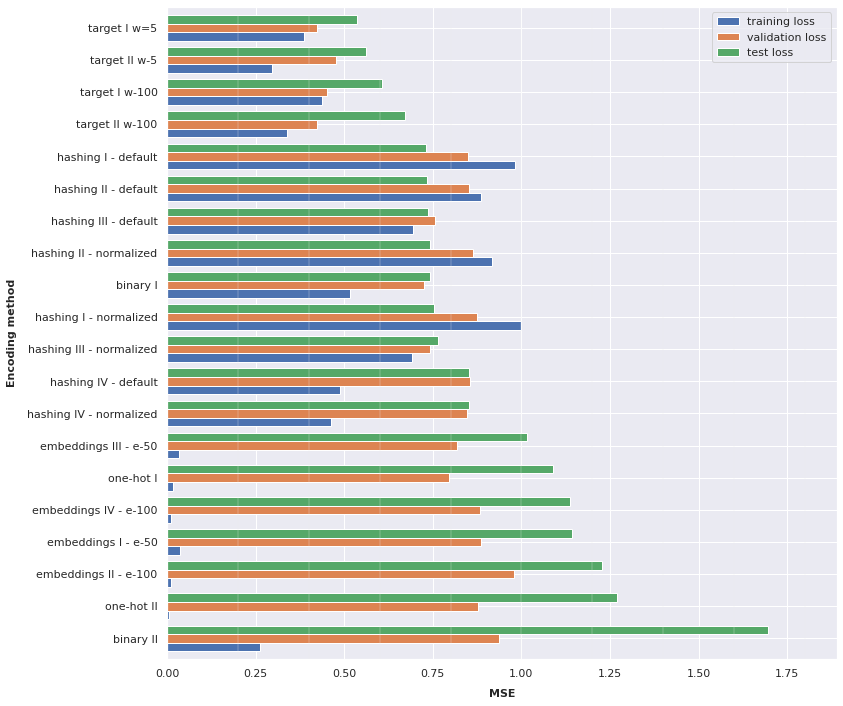

In [137]:
ax = df_final.sort_values(by=['test loss','training loss'],ascending=[False, False]).plot.barh(figsize=(12,12),
                                                                                               width=0.80)
#ax.tick_params(axis="both", which="both", bottom="on", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='solid', alpha=0.2, color='#eeeeee', zorder=1)

ax.set_xlabel("MSE", labelpad=10, weight='bold', size=11)

ax.set_ylabel("Encoding method", labelpad=10, weight='bold', size=11)

### delta Gl

Text(0, 0.5, 'Encoding method')

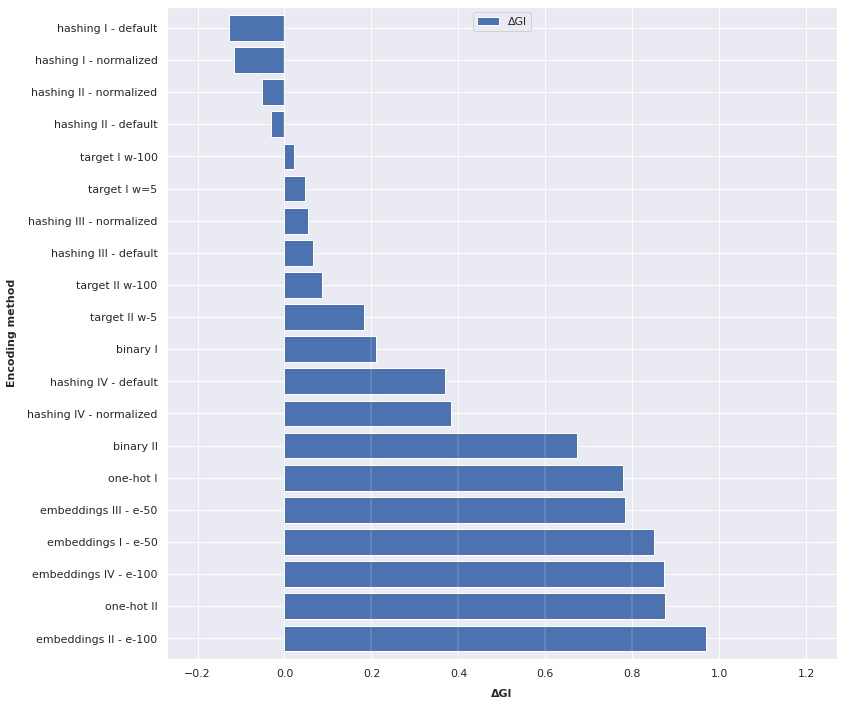

In [136]:
encoding = ['one-hot I','one-hot II','target I w=5','target II w-5','target I w-100','target II w-100',
'binary I','binary II','hashing I - default','hashing II - default','hashing III - default','hashing IV - default',
'hashing I - normalized','hashing II - normalized','hashing III - normalized','hashing IV - normalized',
'embeddings I - e-50','embeddings II - e-100','embeddings III - e-50','embeddings IV - e-100']

delta_Gl = [0.7777, 0.8741, 0.0464, 0.1839, 0.0225, 0.0874, 0.2096, 0.6739, -0.1268, -0.0315, 0.0663, 0.3685, -0.1165,
            -0.0516,0.0545, 0.3834, 0.8500, 0.9702, 0.7837, 0.8720]

df_Gl = pd.DataFrame({'ΔGl': delta_Gl},
                      index=encoding)

ax = df_Gl.sort_values(by=['ΔGl'],ascending=[False]).plot.barh(figsize=(12,12),width=0.80)

vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='solid', alpha=0.2, color='#eeeeee', zorder=1)

ax.set_xlabel("ΔGl", labelpad=10, weight='bold', size=11)

ax.set_ylabel("Encoding method", labelpad=10, weight='bold', size=11)